# MORDM 
- a) Perform MORDM to discover the worst case scenario
- b) Apply MORDM with the worst case scenario to find optimal policies and analyze them

In [1]:
import time, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

#from custom_funcs import *

from ema_workbench import (Model, IntegerParameter, RealParameter, CategoricalParameter, Constant,
                           ScalarOutcome, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import prim, feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
problem_formulation_id = 2
dike_model,planning_steps = get_model_for_problem_formulation(problem_formulation_id)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/6000 nfe
[MainProcess/INFO] generation 1: 100/6000 nfe
[MainProcess/INFO] generation 2: 200/6000 nfe
[MainProcess/INFO] generation 3: 300/6000 nfe
[MainProcess/INFO] generation 4: 400/6000 nfe
[MainProcess/INFO] generation 5: 500/6000 nfe
[MainProcess/INFO] generation 6: 600/6000 nfe
[MainProcess/INFO] generation 7: 700/6000 nfe
[MainProcess/INFO] generation 8: 800/6000 nfe
[MainProcess/INFO] generation 9: 900/6000 nfe
[MainProcess/INFO] generation 10: 1000/6000 nfe
[MainProcess/INFO] generation 11: 1100/6000 nfe
[MainProcess/INFO] generation 12: 1200/6000 nfe
[MainProcess/INFO] generation 13: 1300/6000 nfe
[MainProcess/INFO] generation 14: 1400/6000 nfe
[MainProcess/INFO] generation 15: 1500/6000 nfe
[MainProcess/INFO] generation 16: 1600/6000 nfe
[MainProcess/INFO] generation 17: 1700/6000 nfe
[MainProcess/INFO] generation 18: 1800/6000 nfe
[MainProcess/INFO] generation 19: 1900/6000 nfe
[MainProcess/INFO] generation 

Text(0.5,0,'number of function evaluations')

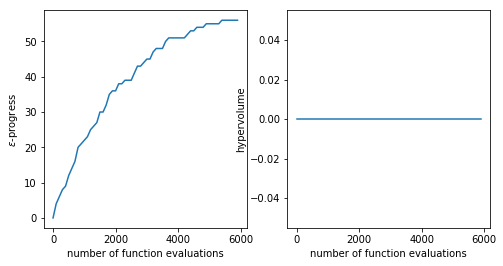

In [6]:
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE
pol0 = {}
for key in dike_model.levers:
    pol0.update({key.name:0})                
policy0 = Policy('Policy 0', **pol0)
for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize
epsilon = [1e2, 1e2,1,1, 0.001]
convergence_metrics = [HyperVolume(minimum=[0, 0, 0, 0, 0], 
                                   maximum=[1e11, 1e10,1e8,1e8, 10]),
                       EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=6000, searchover='uncertainties',epsilons=epsilon,
                                 convergence=convergence_metrics,reference=policy0,logging_freq=1,
                                 convergence_freq=10)
save_results(results,'policy0 6000nfe worst case scenario.tar.gz')
results = load_results('policy0 6000nfe worst case scenario.tar.gz')
scenarios, convergence = results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

[MainProcess/INFO] results loaded succesfully from C:\Users\user\EPA1361\fin_ass\MORDM\policy0 6000nfe worst case scenario.tar.gz


Text(0.5,0,'number of function evaluations')

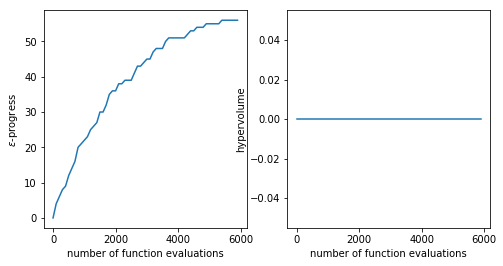

In [4]:
results = load_results('policy0 6000nfe worst case scenario.tar.gz')
scenarios, convergence = results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

[MainProcess/INFO] results saved successfully to C:\Users\user\EPA1361\fin_ass\MORDM\scenario1 MORDMruns_worst case scenario.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\user\EPA1361\fin_ass\MORDM\scenario1 MORDMruns_worst case scenario.tar.gz


Text(0.5,0,'number of function evaluations')

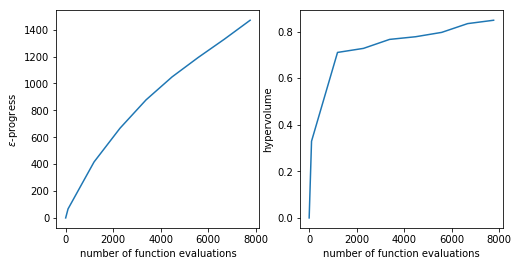

In [9]:
scenario1 = scenarios.loc[0, [u.name for u in dike_model.uncertainties]].to_dict()

for key in scenario1:
    if 'Category' in str(scenario1[key]):
        scenario1[key] = float(scenario1[key].split("'")[1]) # modify Category object to float value
ref_uncertainties = Scenario('reference', **scenario1)
nfe_MORDM = 8000

epsilon = [100, 100, 1, 1, 0.001]

convergence_metrics = [HyperVolume(minimum=[0, 0, 0, 0, 0], 
                                   maximum=[1e10, 1e9,1e8,1e8, 10]),
                       EpsilonProgress()]
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=nfe_MORDM, 
                                 searchover='levers',
                                 epsilons=epsilon,
                                 convergence=convergence_metrics,
                                 reference=ref_uncertainties)

save_results(results, 'scenario1 MORDMruns_worst case scenario.tar.gz')
results = load_results('scenario1 MORDMruns_worst case scenario.tar.gz')

outcomes, convergence = results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')